# Network Analysis

This notebook covers the first half of the assessment on network analysis.

In [40]:
# import the necessary libraries
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import re
import shapely
from scipy.spatial import distance

## Construct the topological network

Based on the `tfl_stations.json` and `tfl_lines.json` files, we will create a network of the underground.

In [41]:
# load data and project into British National Grid
stations = gpd.read_file(os.path.join('data', 'network', 'tfl_stations.json')).to_crs('EPSG:27700')
lines = gpd.read_file(os.path.join('data', 'network', 'tfl_lines.json')).to_crs('EPSG:27700')

### Edit stations data

In [42]:
# clean station names

# get all names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

# clean the names
for k, v in station_names.items():
    if k == 'none':
        continue
    # get rid of everything other than the name itself - like LU / LO / DLR / ( )
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)

    # combine Bank and Monument as 'Bank and Monument'
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name

# save back into the gdf
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [43]:
# change position of station to mean of all stations with the same name

pos = {}

for i, station in stations.iterrows():
    # store coordinates
    xy = station.geometry.coords[0]

    # if station already in dictionary, add coordinate to list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    # else add to list and set coordinate as first item in list
    else:
        pos[station['name']] = [xy]

# iterate through the dictionary to replace coordinate with the mean value
for k, v in pos.items():
    pos[k] = np.mean(v, axis = 0)

# set new geometry
stations['geometry'] = stations['name'].apply(lambda x: shapely.Point(pos[x]))

<Axes: >

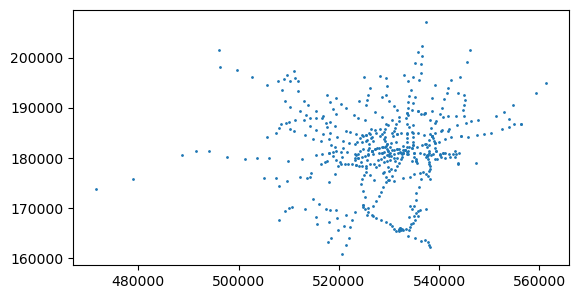

In [44]:
stations.plot(markersize = 1)

### Edit lines data

In [45]:
# get the line names
line_names = lines['lines'].apply(lambda x: [x['name'] for x in json.loads(x)])
line_names = list(set([item for sublist in line_names for item in sublist]))

# Rename the East London Line into the London Overground, as it is part of it
lines['lines'] = lines['lines'].str.replace('East London', 'London Overground')
stations['lines'] = stations['lines'].str.replace('East London', 'London Overground')

# remove the unnecessary lines
remove_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']
for r in remove_lines:
    line_names.remove(r)

line_names


['Circle',
 'Metropolitan',
 'TfL Rail',
 'Hammersmith & City',
 'Piccadilly',
 'Waterloo & City',
 'London Overground',
 'Jubilee',
 'Victoria',
 'Bakerloo',
 'District',
 'DLR',
 'Central',
 'Northern']

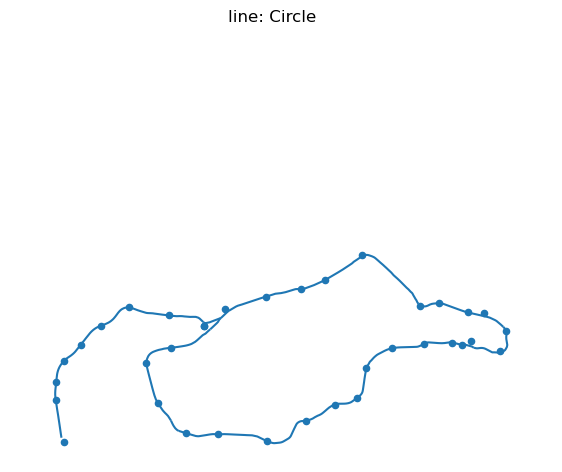

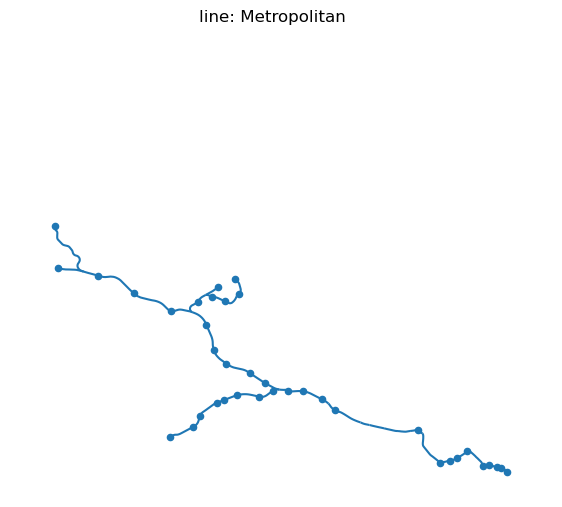

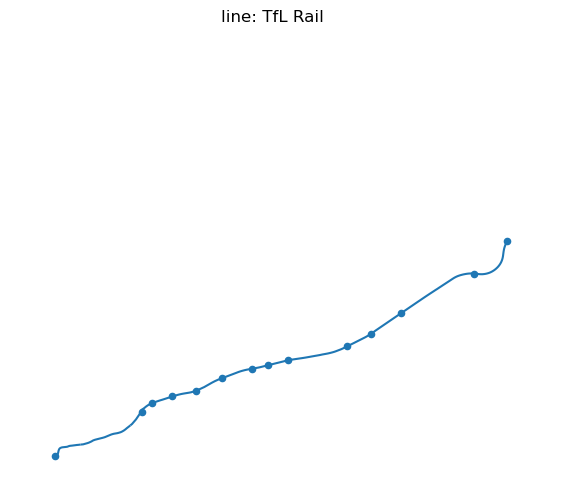

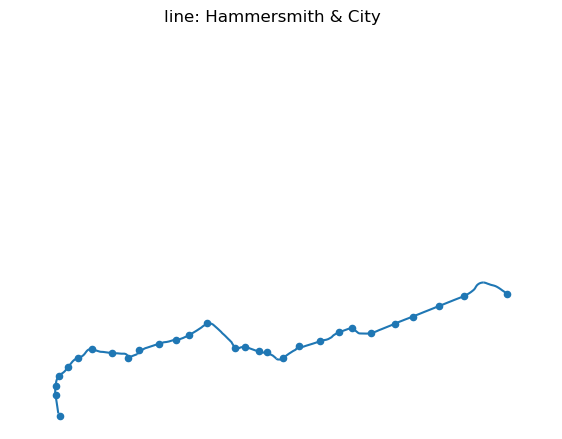

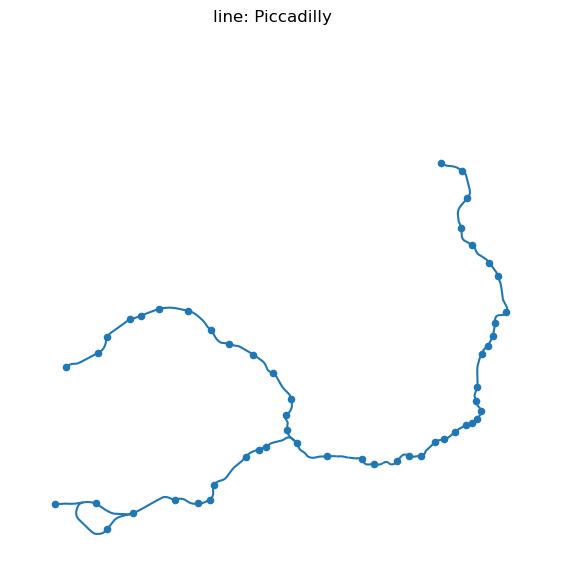

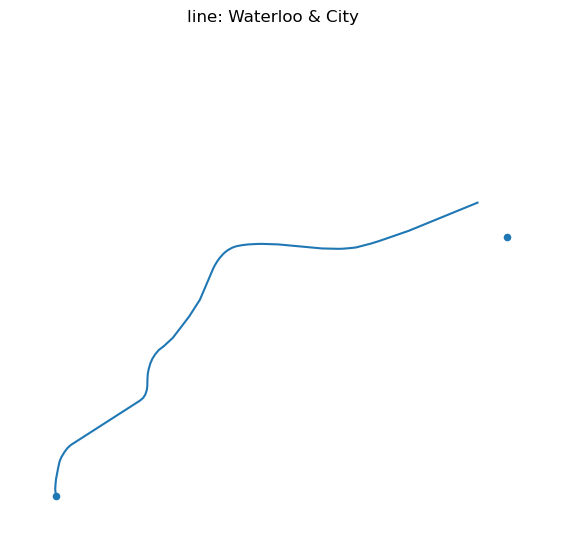

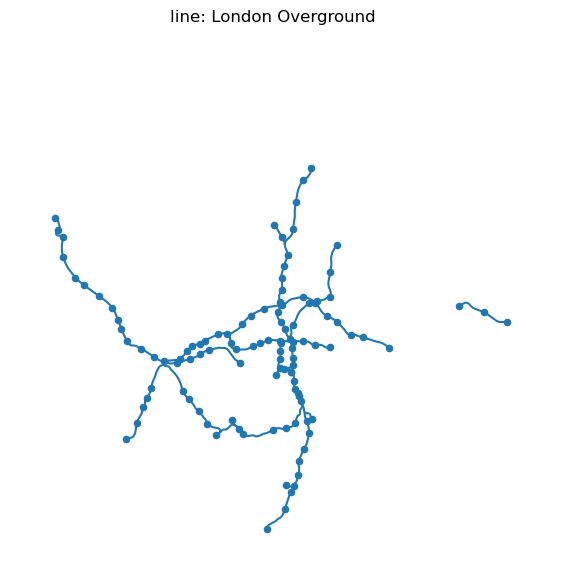

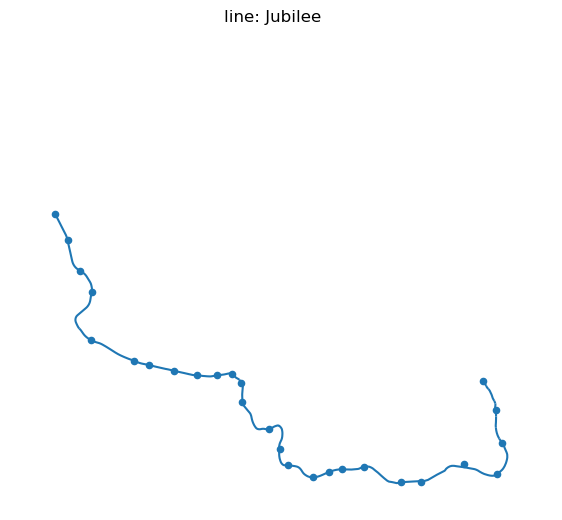

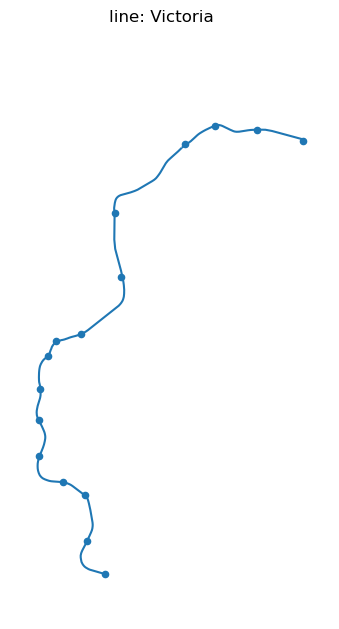

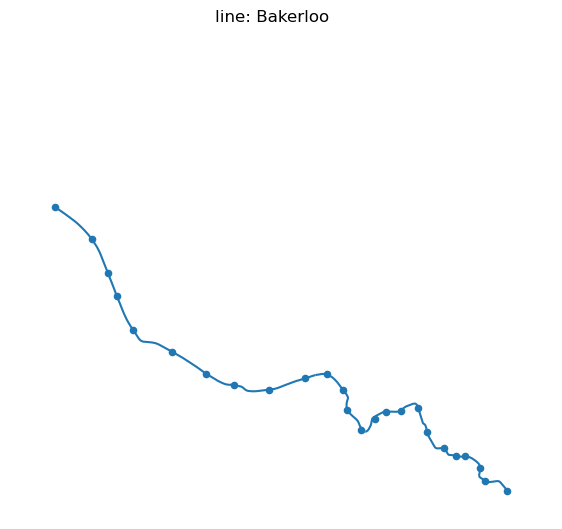

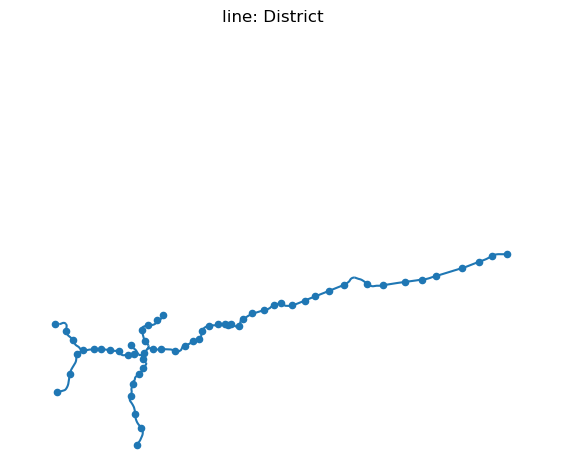

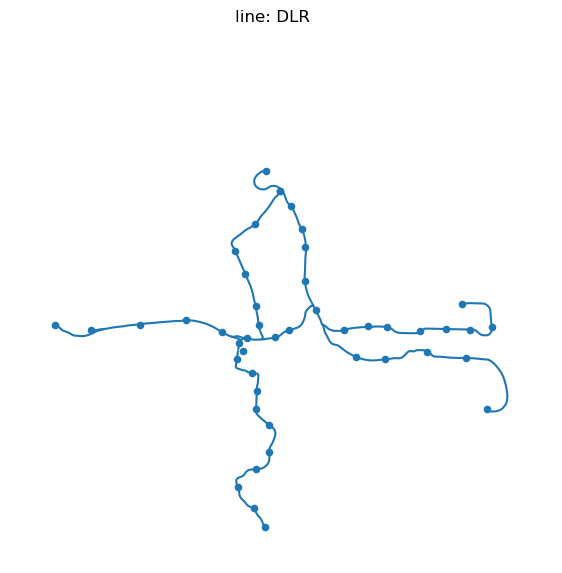

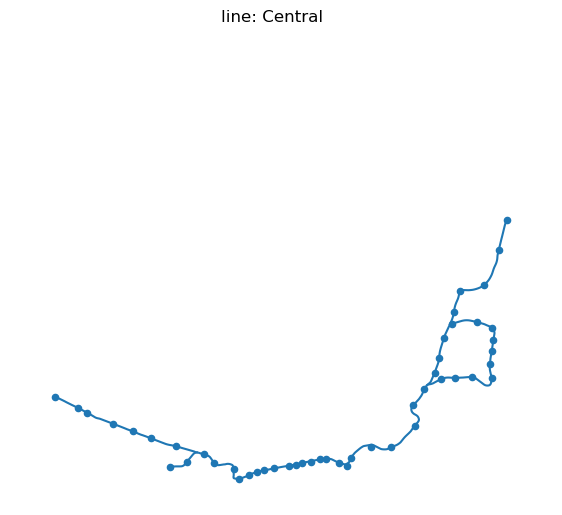

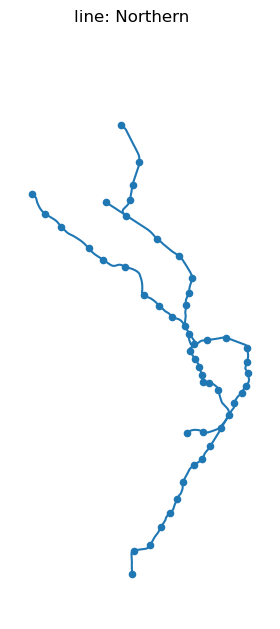

In [46]:
# check the data for each line
for line in line_names:
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()